# Logistic regression implementation

## Initialization

In [44]:
import os
# import time
from datetime import date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression
from sklearn import grid_search
from sklearn.metrics import log_loss
# from packages.helpers import plot_learning_curve

%matplotlib inline

In [12]:
todayDate = date.today().strftime("%Y-%m-%d")

In [53]:
filename = 'logs/' + todayDate + '-lr_log.txt'
dir = os.path.dirname(filename)
if not os.path.exists(dir):
    os.makedirs(dir)

f = open(os.getcwd() + '/../' + filename, 'w')

## Data preparation

In [20]:
train = pd.read_csv(os.getcwd() + '/../data/numerai_training_data.csv')
test = pd.read_csv(os.getcwd() + '/../data/numerai_tournament_data.csv')
example = pd.read_csv(os.getcwd() + '/../data/example_predictions.csv')

X = train.drop('target', axis=1)
y = train.target

Xtest = test.drop('t_id', axis=1)
ID = test.t_id

In [32]:
y.sum()/y.size

0.5051702657807309

## Train-validation split

In [33]:
Xtr, Xval, ytr, yval = cross_validation.train_test_split(X, y, test_size=0.15, random_state=42)

## Logistic regression

In [34]:
lr = LogisticRegression()

### Calculate performance on a validation set

In [35]:
lr.fit(Xtr, ytr)
lr_pred = lr.predict_proba(Xval)
log_loss(yval, lr_pred)

0.69154423519986818

###  Calculate performance using k-fold cross-validation

In [37]:
CVscores = cross_validation.cross_val_score(lr, X, y, scoring='log_loss', cv=5)
CVscores

array([-0.69103482, -0.69221007, -0.69154321, -0.69156723, -0.69186156])

### Search for the regularization parameter

In [39]:
Cs = 10**np.linspace(-4, 4, num=15)
grid = {'C': Cs}
gridsearch = grid_search.GridSearchCV(lr, grid, scoring='log_loss', cv=5)

In [40]:
gridsearch.fit(X, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-04,   3.72759e-04,   1.38950e-03,   5.17947e-03,
         1.93070e-02,   7.19686e-02,   2.68270e-01,   1.00000e+00,
         3.72759e+00,   1.38950e+01,   5.17947e+01,   1.93070e+02,
         7.19686e+02,   2.68270e+03,   1.00000e+04])},
       pre_dispatch='2*n_jobs', refit=True, scoring='log_loss', verbose=0)

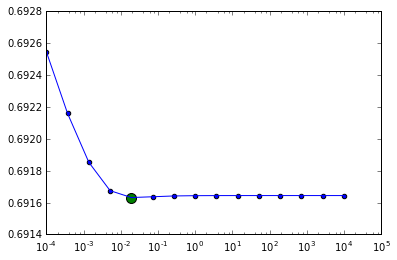

In [45]:
gridscores = [-x.mean_validation_score for x in gridsearch.grid_scores_]
plt.plot(Cs, gridscores)
plt.scatter(Cs, gridscores)
plt.scatter(Cs[np.argmin(gridscores)], gridscores[np.argmin(gridscores)], c='g', s=100)
plt.xscale('log')

In [49]:
C = Cs[np.argmin(gridscores)]

# refit the model with the new regularization parameter
lrCV = LogisticRegression(C=C)
lrCV.fit(Xtr, ytr)

LogisticRegression(C=0.019306977288832496, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [54]:
# write log to file
logloss_train = log_loss(ytr, lrCV.predict_proba(Xtr))
logloss_val = log_loss(yval, lrCV.predict_proba(Xval))
f.write('Train logloss: ' + str(logloss_train) + '\n')
f.write('Validation logloss: ' + str(logloss_val) + '\n')
f.close()

35

In [55]:
# refit using all data
lrCV.fit(X, y)

LogisticRegression(C=0.019306977288832496, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

## Submission

In [56]:
lr_pred = lrCV.predict_proba(Xtest)
lr_submit = pd.DataFrame(lr_pred[:, 1], index=ID, columns={'probability'})

In [59]:
lr_submit.to_csv('../output/' + todayDate + '-lr_submit.csv')